In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque

In [26]:
# Parameters
n = 30 # dimension of actions and/or cost matrix
d = 500 # number of initial sample pairs
total_samples = 10000 # number of total samples that can be used
buff_size = 500 # buffer size of D to make use of newer experiences and limiting the effect of old ones by popping them
alpha = 0.01 # learning rate for when performing gradient descent on b

In [27]:
# Define what you want R to be
R = np.identity(n) # identity matrix
# R = generate_diagonally_dominant_positive_definite_matrix(n)
R = torch.tensor(R, dtype=torch.float32)

In [28]:
# Initialize b to all 2.0s
b = torch.tensor([2.0]*n, requires_grad=True)

In [29]:
# Initialize D to be empty deque
D = deque(maxlen=buff_size)

In [30]:
def generate_diagonally_dominant_positive_definite_matrix(size):
    # add a seed to make the random matrix reproducible
    np.random.seed(42)
    A = np.random.rand(size, size)
    A = A + np.diag(np.sum(np.abs(A), axis=1) + 1)
    A = (A + A.T)/2
    return A

In [31]:
# Cost (reward) function a transpose R a
def reward(a, R):
    return torch.matmul(torch.matmul(a.T,R), a)

In [32]:
# generate a random action given the target parameter b s.t. a = b + N(0,1) (make sure a has entries only [-2,2])
def generate_action(b):
    a = b + torch.normal(0,1,(n,))
    return torch.clamp(a, -2, 2)

In [33]:
# Function for gradient clipping
def clip_gradients(theta, max_norm):
    torch.nn.utils.clip_grad_norm_(theta, max_norm)

In [34]:
# Defining simple MLP for Q where we can change the number of layers and the number of neurons in each layer
class Q_theta(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(Q_theta, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.network(x)

    def loss(self, minibatch):
        loss = 0.0
        for a,r in minibatch:
            loss += (self.forward(a) - r)**2
        loss = loss/len(minibatch)
        return loss

In [35]:
# Function to update the parameters of Q with one step of gradient descent
def update_Q(minibatch, learning_rate, q_model, max_norm=None):
    q_optimizer= optim.Adam(q_model.parameters(), lr=0.001)
    q_optimizer.zero_grad()
    loss = Q.loss(minibatch)
    loss.backward(retain_graph=True)
    if max_norm:
        clip_gradients(Q.parameters(), max_norm)
    q_optimizer.step()

In [36]:
b_optimizer = optim.Adam([b], lr=0.001)

In [37]:
# Define the optimizer for b outside the update_b function, just after b is initialized
b_optimizer = optim.Adam([b], lr=0.000001)

# Modify the update_b function to use the optimizer
def update_b(minibatch, Q, b, b_optimizer):
    b_output = Q.forward(b)
    b_grad = torch.autograd.grad(b_output, b, retain_graph=True)[0]

    b_optimizer.zero_grad()
    b_output.backward()
    b_optimizer.step()

    # gradient clipping
    clip_gradients(b, 1)

    # update b
    with torch.no_grad():
        b -= alpha * b_grad

    return b


In [38]:
# Variant 1: BaseMLP with dynamic buffer 
def MLP2():
    global D, b, R

    # list to store the costs to graph them
    zoomcosts = {}
    # Generate initial sample pairs
    for i in range(d):
        a = generate_action(b)
        r = reward(a, R)
        D.append((a,r))

    for i in range(total_samples - d):

        # generate a random action
        a = generate_action(b)

        # get the reward
        r = reward(a, R)

        # add the new sample pair to D
        D.append((a,r))

    # This is the variant area
    #***************************************************************************************************
        # Deque is full, so remove the oldest sample pair
        if len(D) == buff_size:
            D.popleft()
    #***************************************************************************************************

        # sample a minibatch from D
        minibatch = random.sample(D, 32)

        # update Q with one step of gradient descent
        update_Q(minibatch, alpha, Q, 1.0)

        # update b with one step of gradient descent
        b=update_b(minibatch, Q, b, b_optimizer)

        # print thr reward every 1000 iterations
        if i % 500 == 0:
            print("Cost at iteration ", i, " is ", reward(b, R))
            zoomcosts[i] = reward(b, R)

    # return the costs and the final b
    return reward(b, R), zoomcosts

In [39]:
# this variant adds optimization to the b parameter
costs = []
for iter in range(10):
    global b, D, Q
    # set the seed
    torch.manual_seed(iter)
    np.random.seed(iter)

    # reset the parameters
    b = torch.tensor([2.0]*n, requires_grad=True)
    D = deque(maxlen=buff_size)
    Q = Q_theta(n, 1, 64)

    # run the algorithm
    final_cost, zoomcost = MLP2()
    costs.append(final_cost)

Cost at iteration  0  is  tensor(119.9965, grad_fn=<DotBackward0>)


Cost at iteration  500  is  tensor(4.6234, grad_fn=<DotBackward0>)
Cost at iteration  1000  is  tensor(1.4269, grad_fn=<DotBackward0>)
Cost at iteration  1500  is  tensor(0.6426, grad_fn=<DotBackward0>)
Cost at iteration  2000  is  tensor(0.3151, grad_fn=<DotBackward0>)
Cost at iteration  2500  is  tensor(0.2384, grad_fn=<DotBackward0>)
Cost at iteration  3000  is  tensor(0.2388, grad_fn=<DotBackward0>)
Cost at iteration  3500  is  tensor(0.2882, grad_fn=<DotBackward0>)
Cost at iteration  4000  is  tensor(0.4604, grad_fn=<DotBackward0>)
Cost at iteration  4500  is  tensor(0.6166, grad_fn=<DotBackward0>)
Cost at iteration  5000  is  tensor(0.7204, grad_fn=<DotBackward0>)
Cost at iteration  5500  is  tensor(0.7941, grad_fn=<DotBackward0>)
Cost at iteration  6000  is  tensor(0.7675, grad_fn=<DotBackward0>)
Cost at iteration  6500  is  tensor(0.8298, grad_fn=<DotBackward0>)
Cost at iteration  7000  is  tensor(1.5465, grad_fn=<DotBackward0>)
Cost at iteration  7500  is  tensor(1.5880, grad_

In [40]:
print(costs)
# print the mean cost (they are tensor objects)
print(torch.mean(torch.tensor(costs)))

[tensor(2.5141, grad_fn=<DotBackward0>), tensor(1.4968, grad_fn=<DotBackward0>), tensor(2.8111, grad_fn=<DotBackward0>), tensor(1.9630, grad_fn=<DotBackward0>), tensor(3.1542, grad_fn=<DotBackward0>), tensor(3.2986, grad_fn=<DotBackward0>), tensor(1.1812, grad_fn=<DotBackward0>), tensor(2.1964, grad_fn=<DotBackward0>), tensor(2.6014, grad_fn=<DotBackward0>), tensor(0.3102, grad_fn=<DotBackward0>)]
tensor(2.1527)


[2.5141068 1.4968427 2.8111439 1.9629511 3.154198  3.2986069 1.1811693
 2.196408  2.6013958 0.3101871]
tensor(2.1527)


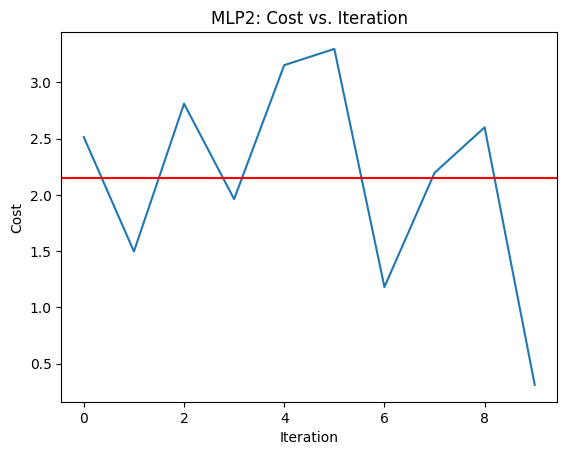

In [43]:
print(costs)
# print the mean cost (they are tensor objects)
print(torch.mean(torch.tensor(costs)))
# convert the costs to a numpy array using detach
costs = torch.tensor(costs).detach().numpy()
# graph the costs
import matplotlib.pyplot as plt
plt.plot(costs)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.title('MLP2: Cost vs. Iteration')
mean = costs.mean()
plt.axhline(y=mean, color='r', linestyle='-', label='Mean Cost')
# plt.show()
# save the figure
plt.savefig('MLP2.png')

In [42]:
zoomcost = dict(zoomcost)

# convert the zoomcosts to a python dictionary

def tensors_to_numpy(tensor_dict):
    numpy_dict = {}
    for key, tensor in tensor_dict.items():
        # Ensure tensor is on CPU before converting
        numpy_dict[key] = tensor.cpu().numpy()
    return numpy_dict

# convert the zoomcosts to a regular dictionary
# zoomcost = tensors_to_numpy(zoomcost)
print(zoomcost)

{0: tensor(120.0000, grad_fn=<DotBackward0>), 500: tensor(6.3460, grad_fn=<DotBackward0>), 1000: tensor(2.4075, grad_fn=<DotBackward0>), 1500: tensor(0.5799, grad_fn=<DotBackward0>), 2000: tensor(0.3543, grad_fn=<DotBackward0>), 2500: tensor(0.3365, grad_fn=<DotBackward0>), 3000: tensor(0.3179, grad_fn=<DotBackward0>), 3500: tensor(0.3179, grad_fn=<DotBackward0>), 4000: tensor(0.3179, grad_fn=<DotBackward0>), 4500: tensor(0.3179, grad_fn=<DotBackward0>), 5000: tensor(0.3179, grad_fn=<DotBackward0>), 5500: tensor(0.3179, grad_fn=<DotBackward0>), 6000: tensor(0.3179, grad_fn=<DotBackward0>), 6500: tensor(0.3168, grad_fn=<DotBackward0>), 7000: tensor(0.3132, grad_fn=<DotBackward0>), 7500: tensor(0.3125, grad_fn=<DotBackward0>), 8000: tensor(0.3100, grad_fn=<DotBackward0>), 8500: tensor(0.3100, grad_fn=<DotBackward0>), 9000: tensor(0.3101, grad_fn=<DotBackward0>)}
